In [1]:
from scipy import io
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("seaborn")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.decomposition import PCA

In [2]:
data = io.loadmat("piececonst_r421_N1024_smooth1.mat")

FileNotFoundError: [Errno 2] No such file or directory: 'piececonst_r421_N1024_smooth1.mat'

In [ ]:
data['coeff'].shape

In [ ]:
def get_data(filename, ndata):
    # 5->85x85, 6->71x71, 7->61x61, 10->43x43, 12->36x36, 14->31x31, 15->29x29
    r = 15
    s = int(((421 - 1) / r) + 1)

    # Data is of the shape (number of samples = 1024, grid size = 421x421)
    data = io.loadmat(filename)
    x_branch = data["coeff"][:ndata, ::r, ::r].astype(np.float64) * 0.1 - 0.75
    y = data["sol"][:ndata, ::r, ::r].astype(np.float64) * 100
    # The dataset has a mistake that the BC is not 0.
    y[:, 0, :] = 0
    y[:, -1, :] = 0
    y[:, :, 0] = 0
    y[:, :, -1] = 0

    grids = []
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grids.append(np.linspace(0, 1, s, dtype=np.float32))
    grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T

    x_branch = x_branch.reshape(ndata, s * s)
    #x = (x_branch, grid)
    y = y.reshape(ndata, s * s)
    return x_branch, y, grid

In [ ]:
x_train, y_train, grid = get_data("piececonst_r421_N1024_smooth1.mat", 1000)
x_test, y_test, grid = get_data("piececonst_r421_N1024_smooth2.mat", 200)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
 y_train[0]

In [ ]:
np.sqrt(841)

# Plotting: piecewise constant problem

In [ ]:
idx = 12
coef = x_train[idx].reshape(29,29)
sol = y_train[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $K(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

In [ ]:
idx = 12
coef = x_test[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

im = ax1.imshow(coef, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Coefficient $K(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

plt.show()

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    # Compute the PCA decoposition
    pca = PCA(n_components=n_pca)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    
    model.fit(x_train_pca, y_train)
    pred= model.predict(x_test_pca)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

# Linear regression

In [ ]:
model = LinearRegression()

n_pca = 10

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [ ]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [ ]:
pca_modes = np.arange(50, 90)
errors = []
for n_pca in pca_modes:
    pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    errors.append(e)

In [ ]:
plt.figure()
plt.plot(pca_modes,errors, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")
plt.show()

In [ ]:
best = np.argmin(errors)
pca_modes[best]

In [ ]:
n_pca = pca_modes[best]

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

In [ ]:
n_pca = 202

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

# Ridge regression

In [ ]:
model = Ridge(alpha = 1e-5)

In [ ]:
pca_modes = np.arange(50, 100)
errors = []
for n_pca in pca_modes:
    pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
    e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
    errors.append(e)

In [ ]:
plt.figure()
plt.plot(pca_modes,errors, '-go')
plt.yscale('log')
plt.title("Error as a function of training size")
plt.show()

In [ ]:
best = np.argmin(errors)
pca_modes[best]

In [ ]:
n_pca = pca_modes[best]

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e, model

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

In [ ]:
n_pca = 202

pred, model = train_test(x_train, x_test, y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

e

# Polynomial Regression: quadratic

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

In [ ]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [ ]:
x_train_poly.shape[-1], x_train_poly.shape

In [ ]:
pca = PCA(n_components=1000)

x_train_pca = pca.fit_transform(x_train_poly)
x_test_pca = pca.transform(x_test_poly)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [ ]:
n_pca

In [ ]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Polynomial Ridge Regression: quadratic

In [ ]:
def train_test(x_train, x_test, y_train, y_test, n_pca, model):
    
    model.fit(x_train, y_train)
    pred= model.predict(x_test)
    #pred_train = gp.predict(x_train)

    #e = compute_error_dataset(y_test, pred, knots, k)

    return pred, model

In [ ]:
poly = PolynomialFeatures(2)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

model = LinearRegression()

In [ ]:
x_train_poly.shape[-1], x_train_poly.shape

In [ ]:
pca = PCA(n_components=1000)

x_train_pca = pca.fit_transform(x_train_poly)
x_test_pca = pca.transform(x_test_poly)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [ ]:
n_pca

In [ ]:
model = Ridge(1e-5)

pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))
e

In [ ]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: Matern 2.5

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [ ]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

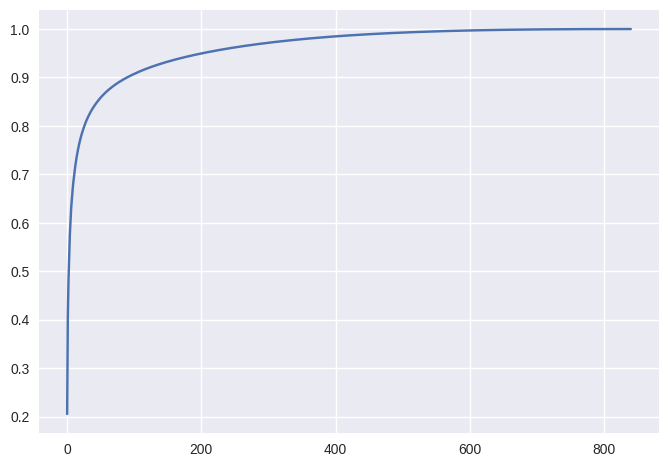

In [161]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [162]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [163]:
model.kernel_, e

(Matern(length_scale=90.4, nu=2.5), 0.029003909100872634)

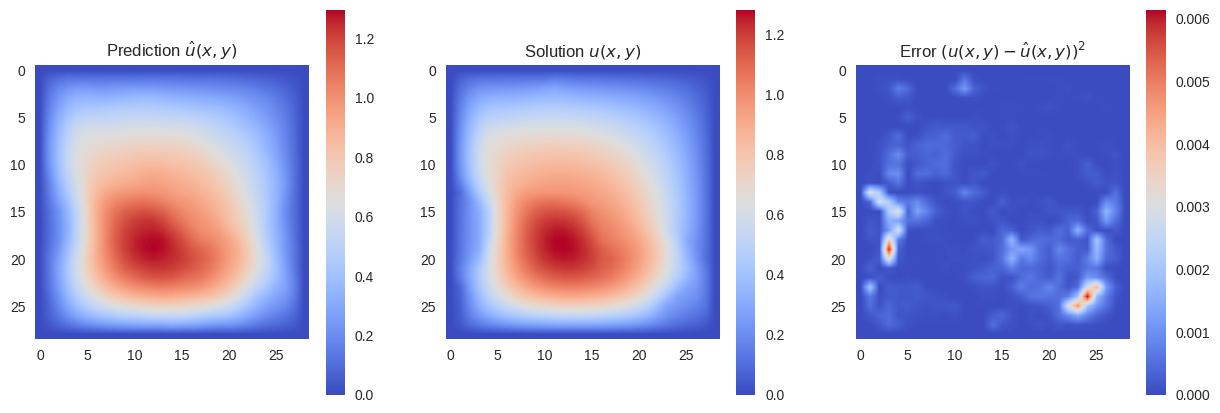

In [164]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: RBF

In [165]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [166]:
#kernel = Matern(nu = 2.5)
kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

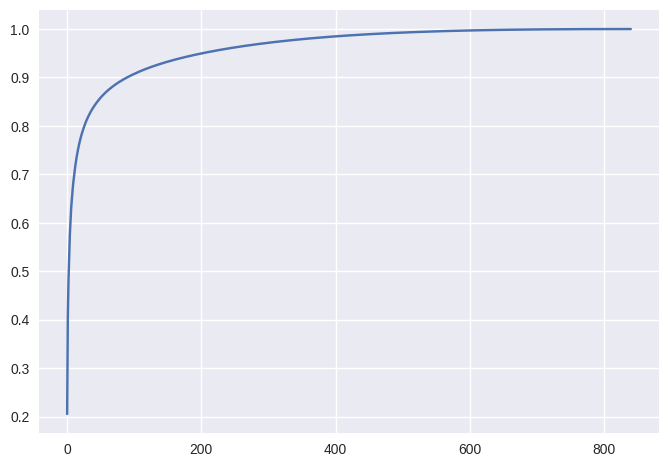

In [167]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [168]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [169]:
model.kernel_, e

(RBF(length_scale=55.4), 0.029821685805713274)

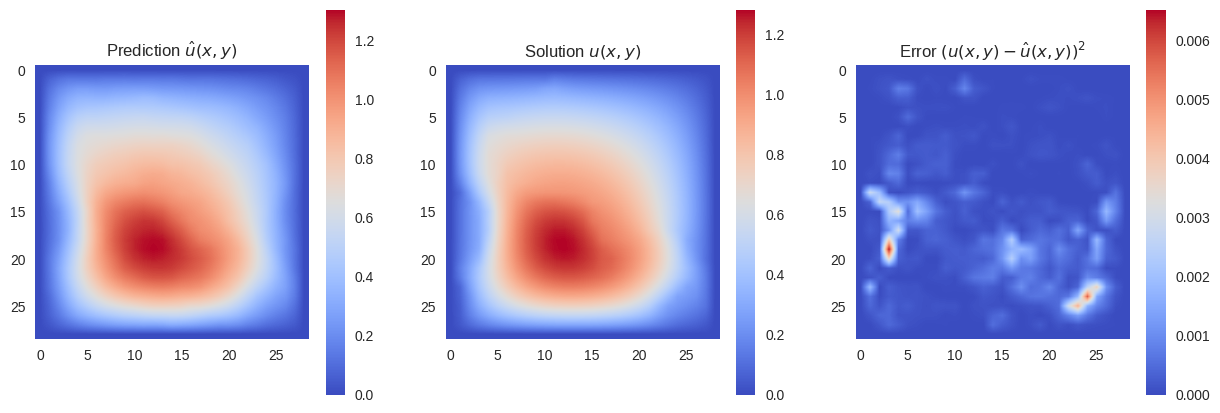

In [170]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: exponential

In [171]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

In [172]:
kernel = Matern(nu = 0.5)
#kernel = RBF()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

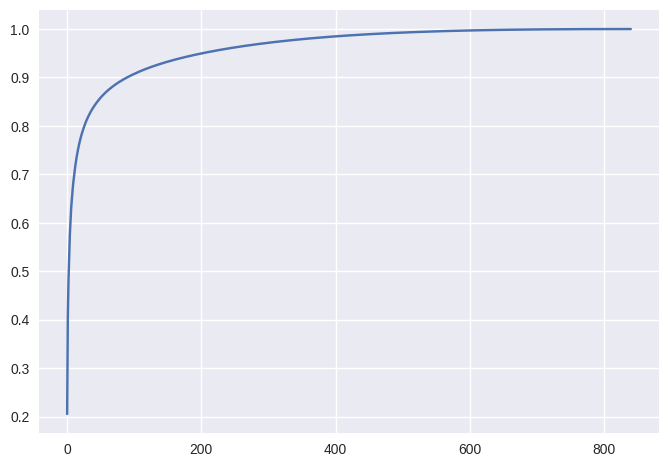

In [173]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [174]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [175]:
model.kernel_, e

(Matern(length_scale=6.66e+03, nu=0.5), 0.0346222370630789)

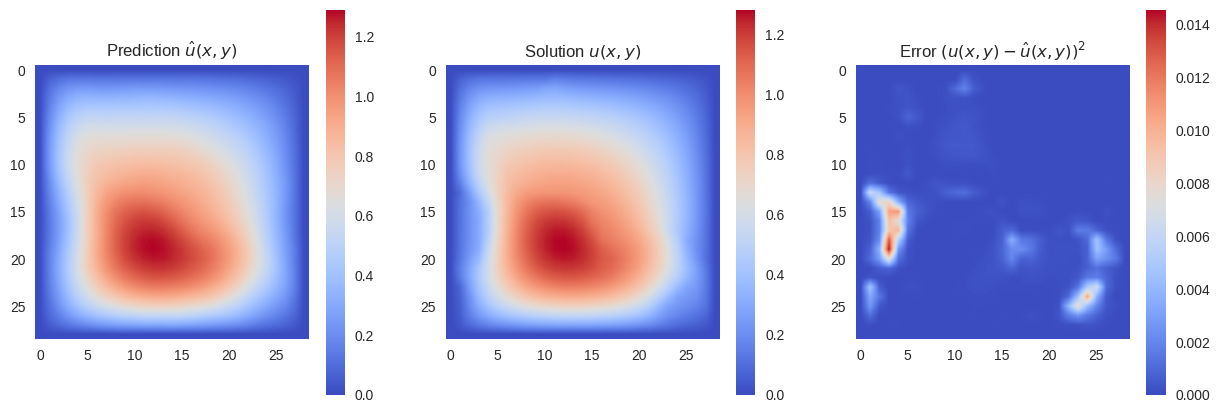

In [176]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: RationalQuadratic

In [181]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

In [182]:
#kernel = Matern(nu = 0.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

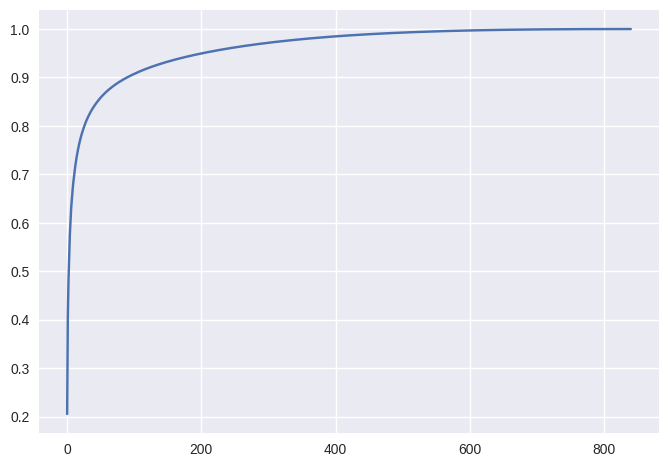

In [183]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]

In [184]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [185]:
model.kernel_, e

(RationalQuadratic(alpha=0.0164, length_scale=146), 0.02874385650647593)

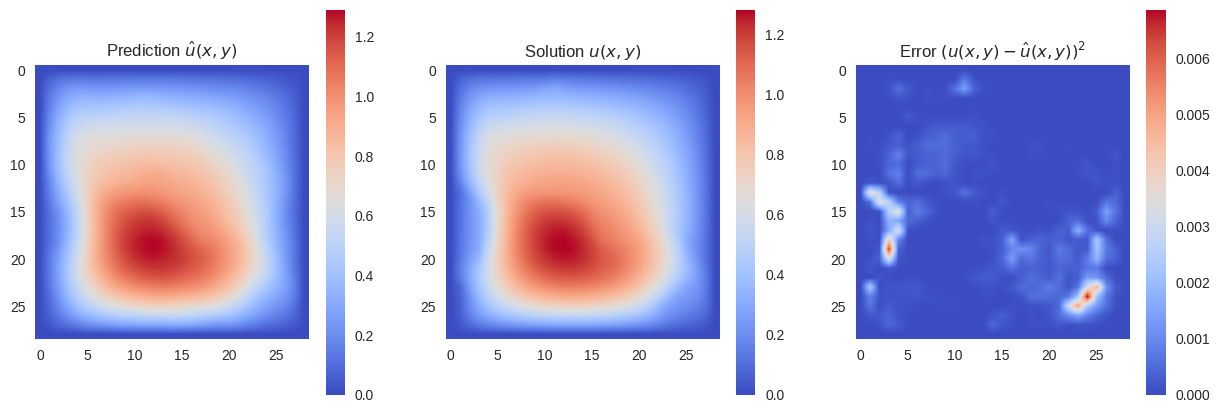

In [186]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: Matern, PCA 0.99

In [187]:
kernel = Matern(nu = 2.5)
#kernel = RBF()
#kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

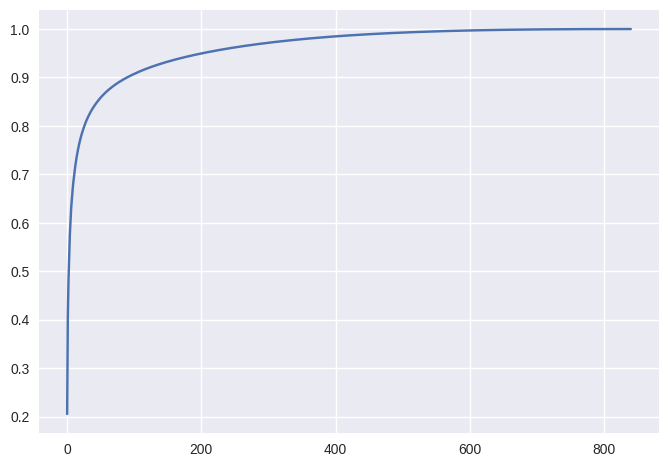

459

In [189]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n_pca

In [190]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [191]:
model.kernel_, e

(Matern(length_scale=101, nu=2.5), 0.033880811812282426)

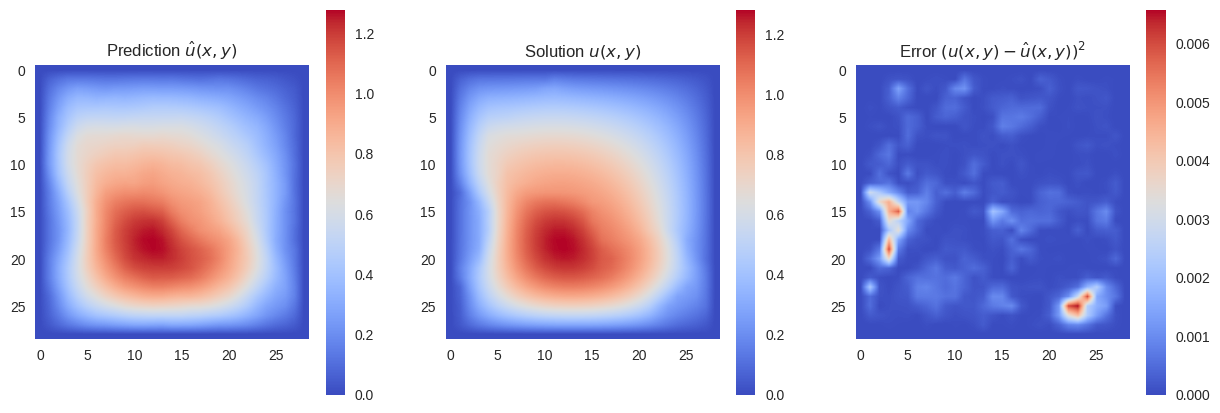

In [192]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: Rational Quadratic, PCA 0.99

In [193]:
#kernel = Matern(nu = 2.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

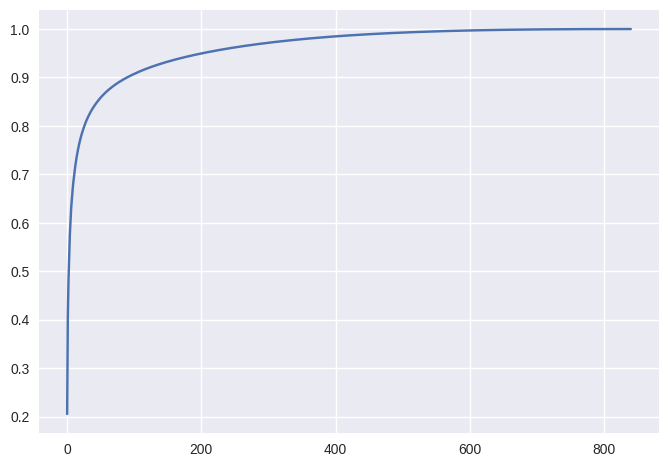

459

In [194]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n_pca

In [195]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [196]:
model.kernel_, e

(RationalQuadratic(alpha=0.0103, length_scale=173), 0.030926479147757018)

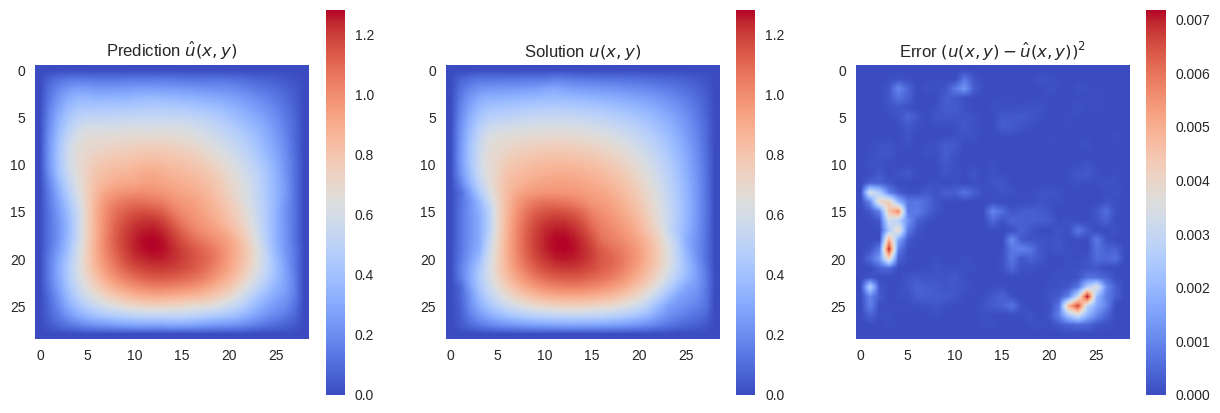

In [197]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()

# Gaussian Process: Rational Quadratic, PCA 0.90

In [198]:
#kernel = Matern(nu = 2.5)
#kernel = RBF()
kernel = RationalQuadratic()
model = GaussianProcessRegressor(kernel, alpha = 1e-10) 

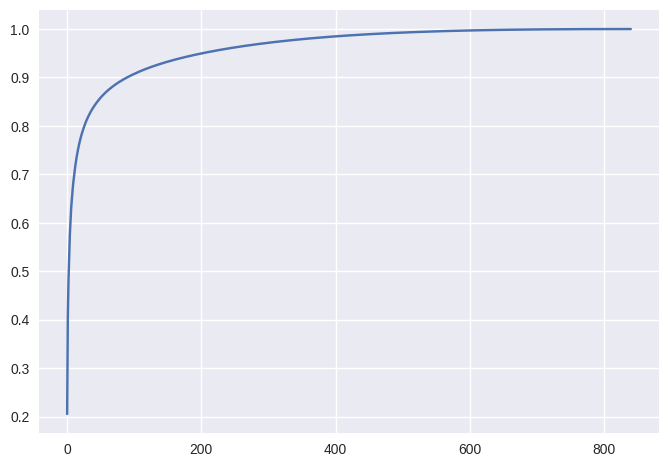

90

In [199]:
pca = PCA(n_components=x_train.shape[-1])

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.90)[0][0]
n_pca

In [200]:
pred, model = train_test(x_train_pca[:, :n_pca], x_test_pca[:, :n_pca], y_train, y_test, n_pca, model)
e = np.mean(np.linalg.norm(pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1))

In [201]:
model.kernel_, e

(RationalQuadratic(alpha=0.0226, length_scale=119), 0.029203014701820563)

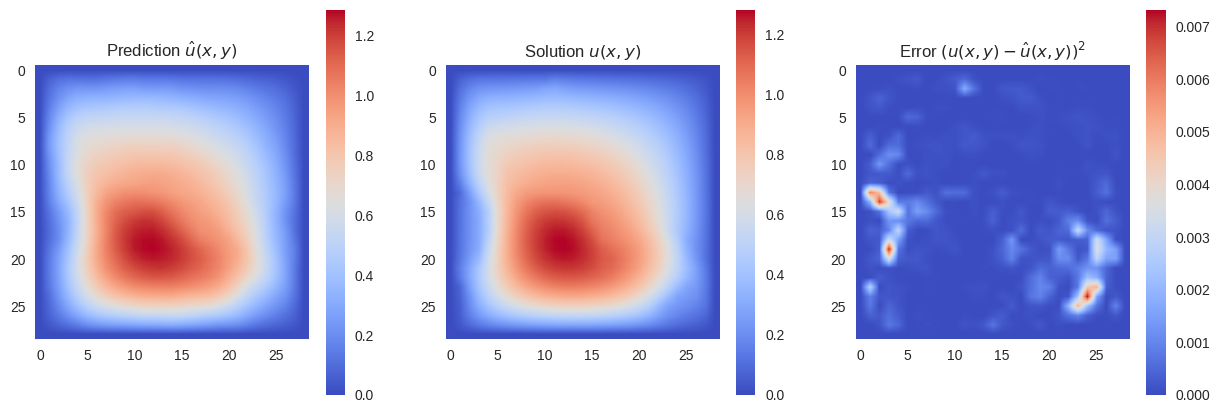

In [202]:
idx = 20
sol_pred = pred[idx].reshape(29,29)
sol = y_test[idx].reshape(29,29)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))

im = ax1.imshow(sol_pred, interpolation='bilinear', cmap= "coolwarm")
ax1.grid(visible=None)
fig.colorbar(im, ax=ax1)
ax1.set_title(r"Prediction $\hat{u}(x,y)$")

im = ax2.imshow(sol, interpolation='bilinear', cmap= "coolwarm")
ax2.grid(visible=None)
fig.colorbar(im, ax=ax2)
ax2.set_title(r"Solution $u(x,y)$")

im = ax3.imshow((sol - sol_pred)**2, interpolation='bilinear', cmap= "coolwarm")
ax3.grid(visible=None)
fig.colorbar(im, ax=ax3)
ax3.set_title(r"Error $(u(x,y) - \hat{u}(x,y))^2$")

plt.show()